# Kidney Segmentation for the KITs19 Challenge
**Authors:** Aayush Bajaj (z5362216), Song, Marc, Liam, Samuel
**Date:** November, 2024

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Sources](#Data-Sources)
3. [Exploratory Analysis](#Exploratory-analysis)
4. [Models and Methods](#Models-methods)
5. [Results](#results)
6. [Discussion](#discussion)
7. [Writing](#writing)

<a id="Introduction"></a>
## 1. Introduction

The project we selected was number 018: Kidney (and tumour) segmentation. The purpose of which is to accurately segment kidneys from computed tomography (CT) scans using machine learning. Manual segmentation of the imaged organs for diagnosis has always taken quite long manually, and inconsistent in quality depending on the skill of the radiologist. By using the speed and effectiveness of AI-assisted image segmentation, initial diagnosis can be done much faster at a more consistent rate.

In this project we implement the models of U-Net, V-Net, SAM-Net and nnU-Net and evaluate their effectiveness in use for medical image segmentation.

<a id=Data-Sources></a>
## 2. Data Sources
The dataset is the same used for the Kits19 Grand Challenge. It is sourced from the University of Minnesota Medical Center and contains 300 selected CT imaging scans from patients who underwent nephrectomy (kidney surgery) for one or more kidney tumors.

The imaging is provided in NIFTI format, a 3D format typically with shape (n x 512 x 512). More detail on the shape of the imagery is provided below in the Exploratory Analysis.

Manual segmentation labels were produced and confirmed by medical students to be used as target masks. Background features were labelled 0, with kidneys labelled 1 and the tumours labelled 2.

<a id="Exploratory-analysis"></a>
## 3. Exploratory Analysis




### Starter Code
Our initial directory hierarchy looked like:
```
├── starter_code
│   ├── evaluation.py
│   ├── get_imaging.py
│   ├── get_imaging_v2.py
│   ├── __init__.py
│   ├── __pycache__
│   ├── utils.py
│   └── visualize.py

```
Where the above `starter_code` directory was provided by the associated [grandchallenge](https://kits19.grand-challenge.org/) [github](https://github.com/neheller/kits19).

Upon running the `get_imaging.py` file, another directory named `data` was populated with 300 case files of the patients described [above](#2-Data-Sources):

```
data
├── case_00000
│   ├── imaging.nii.gz
│   └── segmentation.nii.gz
├── case_00001
│   ├── imaging.nii.gz
│   └── segmentation.nii.gz
...
├── case_00298
│   └── imaging.nii.gz
├── case_00299
│   └── imaging.nii.gz
├── kits.json
└── LICENSE
```

Here, we had both the volume data and segmentation mask data for the first 210 patients, but only had access to the volume data for the remaining 90 patients. This is reflected in the above output of `tree -L 3`

For each of the first 210 patients, we had 2 files: `imaging.nii.gz` and `segmentation.nii.gz`. The first of these contained the 3D medical images obtained via CT (Computed Tomography) scans and the latter, the segmentation masks (or ternary masks) for the kidney and kidney tumours.


Taking averages over the 300 patients, the average disk-size of the CT volume was 91.57MB, and that of the segmentation mask was 0.30MB. Overall, the `data` directory was 26.9GiB in size.



### Visualisations
The next step would be to leverage the `starter_code` files to gain some insight on the data itself. Running the `visualize.py` file as a module in python we were able to stitch together some GiF's:

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: left;">
        <img src="axial.gif" alt="GIF 1" style="width: 100%; max-width: 200px;">
        <p>Axial</p>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="coronal.gif" alt="GIF 2" style="width: 100%; max-width: 200px;">
        <p>Coronal</p>
    </div>
    <div style="flex: 1; text-align: right;">
        <img src="sagittal.gif" alt="GIF 3" style="width: 100%; max-width: 200px;">
        <p>Sagittal</p>
    </div>
</div>

Here, the <span style="color: red;">red</span> indicates a Kidney and the <span style="color: blue;">blue</span> indicates a tumour!

Note: we omit this code, because we did not write it, and it is freely available at the [Kits19 Github](https://github.com/neheller/kits19)



### Properties
In doing this visualisation, we were led to a small discovery: the **sagittal** and **coronal** slices would always output 512 files. This was both an insight and a small curse because, given this, we felt the need to remove these pre-processing lines from our pipeline:

```
        img_resized = cv2.resize(img_slice, target_size, interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, target_size, interpolation=cv2.INTER_NEAREST)
```
This will prove to be one of our challenges [below](#challenges)

We then plotted the slices for every case usinge the following code



Highest number of axial slices: 1059 (Case ID: 00151)
Lowest number of axial slices: 29 (Case ID: 00061)
Average number of axial slices: 217.21


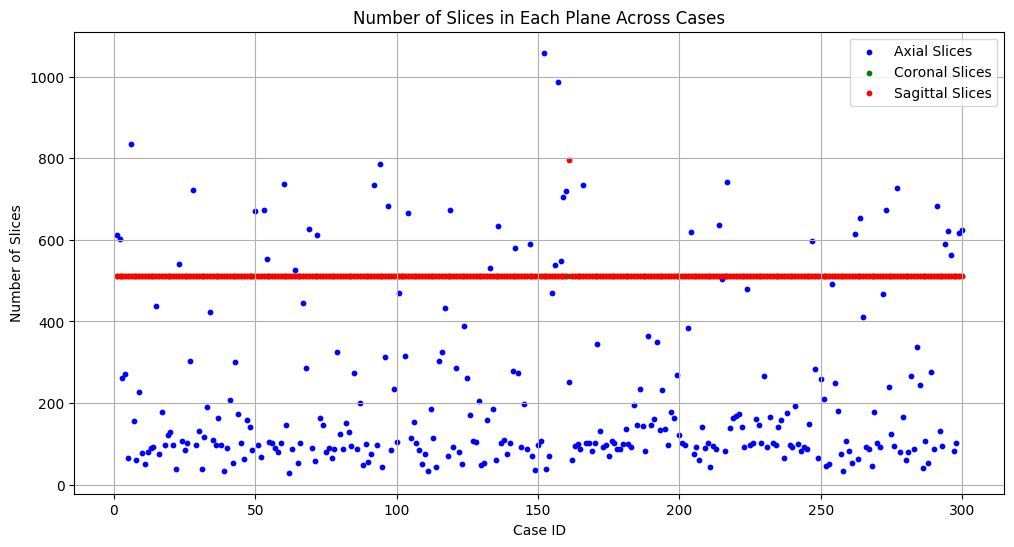

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from starter_code.utils import load_volume

axial_slices = []
coronal_slices = []
sagittal_slices = []


for case_id in range(0, 300):
    case_str = f"{case_id:05d}"
    volume = load_volume(case_str)
    vol_shape = volume.shape

    axial_slices.append(vol_shape[0])
    coronal_slices.append(vol_shape[1])
    sagittal_slices.append(vol_shape[2])

highest_axial = max(axial_slices)
lowest_axial = min(axial_slices)
average_axial = np.mean(axial_slices)

highest_case = axial_slices.index(highest_axial)
lowest_case = axial_slices.index(lowest_axial)

print(f"Highest number of axial slices: {highest_axial} (Case ID: {highest_case:05d})")
print(f"Lowest number of axial slices: {lowest_axial} (Case ID: {lowest_case:05d})")
print(f"Average number of axial slices: {average_axial:.2f}")

cases = np.arange(1, 301)

plt.figure(figsize=(12, 6))
plt.scatter(cases, axial_slices, label="Axial Slices", color="blue", s=10)
plt.scatter(cases, coronal_slices, label="Coronal Slices", color="green", s=10)
plt.scatter(cases, sagittal_slices, label="Sagittal Slices", color="red", s=10)

plt.xlabel("Case ID")
plt.ylabel("Number of Slices")
plt.title("Number of Slices in Each Plane Across Cases")
plt.legend()
plt.grid(True)
plt.show()

Clearly, it can be seen that the number of sagittal and coronal slices are constant __except__ at case 160. Unfortunately, we ran the script to preprocess the data before doing a deep enough data analysis. As such the 21GiB of compressed `PyTorch` files had to be recreated after once again introducing the `resizing` as mentioned above.

Some further discussion on the above line chart is warranted. There is a high degree of variability in the number of axial slices. The highest number is 1059 on Case 151. The lowest number of slices is 29 for Case 61, and the average number of slices is 217.21


### Classes

We had 3 classes:
1. Background: the pixels not containing a kidney or a tumour
2. Kidney: The normal kidney tissue
3. Tumour: The tumorous regions within the kidney

They can be presented from hu distribution:

In [ ]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from starter_code.utils import load_case, load_volume

case = 78
vol, seg = load_case(case)

vol = vol.get_fdata()
seg = seg.get_fdata()

vol_hus = []
seg_hus = []
for i in range(vol.shape[0]):
    for j in range(vol.shape[1]):
        for k in range(vol.shape[2]):
            vol_hus.append(vol[i, j, k])
            seg_hus.append(seg[i, j, k])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(vol_hus, color='blue', edgecolor='black')
plt.title('Image HU Distribution')
plt.xlabel('HU')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(seg_hus, color='red', edgecolor='black')
plt.title('Mask HU Distribution')
plt.xlabel('HU')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Here is the output:

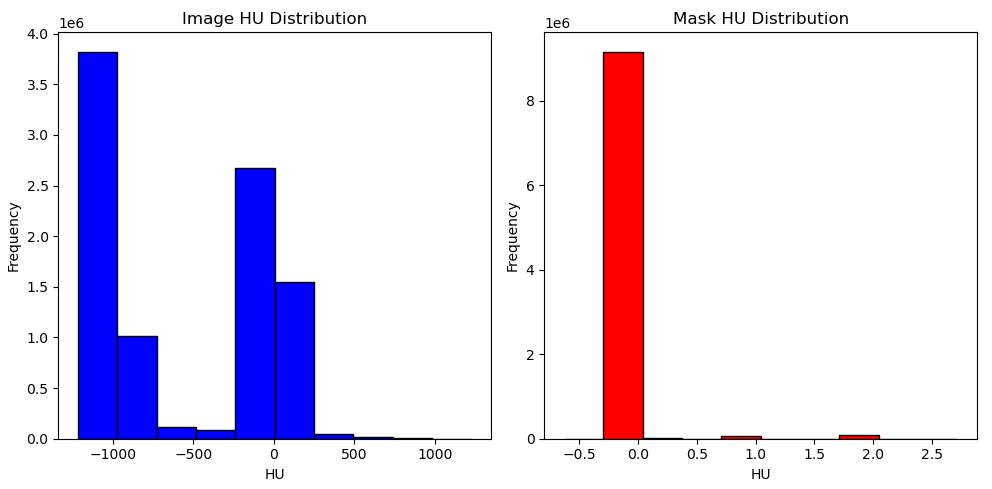

Image Hu distribution:

Hounsfield values (HU) of images are between -1000 and 1000. Background occupies about 60% of an image, which has HU values close to -1000. The human body and organs share the left 40% with HU values close to 0. Other values are basicallly noise.

Mask Hu distrubution:

Hounsfield values (HU) of masks have 3 values: 0, 1 and 2, which Corresponding to three classes


### Pre-processing

This was one of our challenges; understanding what to pre-process (image or the segmentation mask), by how much, and which preprocessing steps are best for our problem. We've already mentioned the slight back and forth that happened with doing resizing, then not doing resizing because everything appeared to be resized; but then ultimately needing to come back and resize because one of our networks choked on Case 160.

But eventually we decided on the following pre-processing steps:
1. Normalisation: Rescaling the pixel intensity values between 0 and 255. Computationally we used `int8` to represent this information
2. Resampling: Adjusting the voxel dimensions to a consistent size. Note, this changes the number of slices!
3. Resizing: Adjusting the volume size to a standard input shape of `256x256xN`. This dimensionality was reduced from 512 because our hardware is limited.
4. Z-Score: Not applied to Segmentation Mask. Allows for faster convergence when input is mean close to 0 and sd close to 1
5. Hounsfield Unit Restriction: Applied only to Volume as they are continuous intensity values.

In [ ]:
import torch
import numpy as np
import cv2
from pathlib import Path
from scipy.ndimage import zoom
from starter_code.utils import load_case, load_volume
import nibabel as nib
from torch.utils.data import Dataset, DataLoader

#constants
TARGET_VOXEL_SPACING = [3.22, 1.62, 1.62]
DEFAULT_HU_MAX = 304
DEFAULT_HU_MIN = -79
DEFAULT_SLICE_SIZE = 512
DEFAULT_PLANE = "axial"
DATASET_START = 0
DATASET_END = 300

#auxillary functions for preprocessing
def resample(image, original_spacing, target_spacing=TARGET_VOXEL_SPACING):
    # Compute zoom factor
    resize_factor = np.array(original_spacing) / np.array(target_spacing)
    resampled_image = zoom(image, resize_factor, mode='nearest')
    return resampled_image

def restrict_hu(image, hu_min=DEFAULT_HU_MIN, hu_max=DEFAULT_HU_MAX):
    # Clip at max and min values if specified
    restrict_image = np.clip(image, hu_min, hu_max)
    return restrict_image

def z_score(image):
    mean = np.mean(image)
    std = np.std(image)
    z_score_image = (image - mean) / std
    return z_score_image

def trans_to_2d(image, plane=DEFAULT_PLANE):
    plane = plane.lower()

    plane_opts = ["axial", "coronal", "sagittal"]
    if plane not in plane_opts:
        raise ValueError((
            "Plane \"{}\" not understood. "
            "Must be one of the following\n\n\t{}\n"
        ).format(plane, plane_opts))

    if plane == plane_opts[0]:
        slices = [image[i, :, :] for i in range(image.shape[0])]

    if plane == plane_opts[1]:
        slices = [image[:, i, :] for i in range(image.shape[1])]

    if plane == plane_opts[2]:
        slices = [image[:, :, i] for i in range(image.shape[2])]

    return slices

def resize(slices):
    resized_slices = [cv2.resize(s, (DEFAULT_SLICE_SIZE, DEFAULT_SLICE_SIZE)) for s in slices]
    return resized_slices


# the main function to be called.
def preprocess(case_id, hu_min=DEFAULT_HU_MIN, hu_max=DEFAULT_HU_MAX):
    vol, seg = load_case(case_id)

    # splitting up cases
    if case_id < 210:
        vol, seg = load_case(case_id)
        seg_present = True
    else:
        vol = load_volume(case_id)
        seg_present = False

    # voxel spacing and resampling
    vol_spacing = nib.affines.voxel_sizes(vol.affine)
    vol = resample(vol.get_fdata(), vol_spacing)

    # restrict hu and apply z_score normalisation to VOLUME ONLY
    vol = restrict_hu(vol, hu_min, hu_max)
    vol = z_score(vol)

    # transform to 2D slices and resize
    vol_slices = resize(trans_to_2d(vol))
    vol_tensors = [torch.tensor(vol_slice, dtype=torch.float32).unsqueeze(0) for vol_slice in vol_slices]

    # If segmentation is available, process it
    if seg_present:
        seg = resample(seg.get_fdata(), vol_spacing)
        seg_slices = resize(trans_to_2d(seg))
        seg_tensors = [torch.tensor(seg_slice, dtype=torch.long).unsqueeze(0) for seg_slice in seg_slices]
        return vol_tensors, seg_tensors
    else:
        return vol_tensors, []

# preprocess images with segmentations
for batch in range(0, 21):
    print(f'Preprocessing train set {batch} ... ', end = '')

    all_vol_tensors = []
    all_seg_tensors = []

    for cid in range(10*batch, 10*(batch+1)):
        if cid != 160:
            vol_tensors, seg_tensors = preprocess(cid)
            all_vol_tensors.extend(vol_tensors)
            all_seg_tensors.extend(seg_tensors)

    train_set = KidneyDataset(all_vol_tensors, all_seg_tensors)
    output_path = Path("preprocessed_data")
    if not output_path.exists():
        output_path.mkdir()
    output_path = output_path / 'train_set_{}'.format(batch)
    torch.save(train_set, output_path)
    print(f'Finished. The number of samples: {len(train_set)}')

# preprocess images without segmentations
for batch in range(21, 30):
    print(f'Preprocessing test set {batch} ... ', end = '')

    test_set = []

    for cid in range(10*batch, 10*(batch+1)):
        vol_tensors, seg_tensors = preprocess(cid)
        test_set.extend(vol_tensors)

    output_path = Path("preprocessed_data")
    if not output_path.exists():
        output_path.mkdir()
    output_path = output_path / 'test_set_{}'.format(batch)
    torch.save(test_set, output_path)
    print(f'Finished. The number of samples: {len(test_set)}')



<a id="challenges"></a>
### Challenges
The challenges have been sprinkled throughout the narrative thus far, but to recap: To resize or not to resize? Should we apply this to the segmentation mask too? What preprocessing steps can we take to speed up the convergence of our models?

1. Resizing.
Yes, do it. It's better to mould things with your cookie-cutter and have them be the exact same before putting them into the oven, instead of risking it and breaking the oven. I'm looking at you Case 160.
2. Do we do it to the segmentation mask too?
No, not always. You ought to understand the structure of the data. The segmentation mask is a ternary mask with 0.0 representing background, 1.0 representing kidney, and 2.0 representing tumour. As such, the _imaging volume_ is continuous and can be subject to HU-reduction and z-score normalisation, but the segmentation mask should not be.
3. Z-score normalisation and resampling. To figure this out we had to study neural network design and look at existing literature to see real world examples of trying to train models on this dataset and copy which preprocessing steps worked.


<a id="Models-methods"></a>
## 4. Models and Methods



### 4.1 UNet
Named for the U-shape of its architecture, UNet is a deep learning neural network originially introduced for 2D medical image segmentaiton. It uses an encoder-decoder structure with skip connections in order to take advantage of the contextual information avaliable within the image. UNet has specific advantages with limited labelled data which makes it adept for different genres of task from medical imagery to satellite imagery. Due to the nature of most medical imagery taking place in 3D via CT scan or MRI, there have been many adaptations of UNet for 3D input since the publishing of the original network in 2015. However, due to hardware, time and computational constraints, we have implemented the original 2D network as a point of comparison.

Due to the age of the nearly decade-old network, the implementation for the network is well-documented and numerous. For our use, we have built our UNet upon a pre-existing implementation found in https://github.com/uygarkurt/UNet-PyTorch and adapted the code to use our pre-processed 2D kidney slices as dataset.


In [ ]:
# UNet imports
import torch
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [ ]:
# Hyperparameters and paths
LEARNING_RATE = 2e-4
EPOCHS = 10
BATCH_COUNT = 2 # 2 training sets
VAL_BATCH_COUNT = [19] # 1 validation set
TEST_SET = 20 # For calculating Dice Score
DATA_PATH = Path() / "preprocessed_data"

We acquire the learning rate and optimal epoch count mostly from trial and error to observe most effective training and when the network starts overfitting.
The original dataset consisting of 210 masked images is "small" in numbers, but when sliced into 2D, the size of the dataset multiplies approximately 100 fold, resulting in around 21000 images in total. Due to hardware and time constraints, the whole dataset thus could not be utilised, and we select instead two batches (approximately 2200 images and masks) to train on, one separate set (approximately 1000 images) for validation, and a test set (approximately 1000 images) for calculating our dice coefficient.

In [ ]:
# Model components for the convolution, downsampling and upsampling
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
        )

    def forward(self, x):
        return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [ ]:
# The UNet model itself as per the described architecture
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.dc1 = DownSample(in_channels, 64)
        self.dc2 = DownSample(64, 128)
        self.dc3 = DownSample(128, 256)
        self.dc4 = DownSample(256, 512)

        self.bn = DoubleConv(512, 1024)

        self.uc1 = UpSample(1024, 512)
        self.uc2 = UpSample(512, 256)
        self.uc3 = UpSample(256, 128)
        self.uc4 = UpSample(128, 64)

        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down1, p1 = self.dc1(x)
        down2, p2 = self.dc2(p1)
        down3, p3 = self.dc3(p2)
        down4, p4 = self.dc4(p3)

        bn = self.bn(p4)

        up1 = self.uc1(bn, down4)
        up2 = self.uc2(up1, down3)
        up3 = self.uc3(up2, down2)
        up4 = self.uc4(up3, down1)

        output = self.output(up4)
        return output


In [ ]:
# Initialisation, optimiser and loss function
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels = 1, num_classes = 1).to(device)
optimiser = optim.AdamW(model.parameters(), lr = LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Dataset definition
class KidneyDataset(Dataset):
    def __init__(self, volumes, masks):
        self.volumes = volumes
        self.masks = masks

    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
        return self.volumes[idx], self.masks[idx]

In [ ]:
# Storage of loss for graphing
loss_over_time = []
val_loss_over_time = []

test_path = DATA_PATH / "train_set_{}".format(TEST_SET)
test_dataset = torch.load(test_path, map_location=device, weights_only=False)
test_data = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_data_count = len(test_data)

In [ ]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()

    validation_loss = 0
    training_loss = 0
    data_count = 0

    # Training
    for batch_index in range(BATCH_COUNT):
        train_path = DATA_PATH / "train_set_{}".format(batch_index)
        train_dataset = torch.load(train_path, map_location=device, weights_only=False)
        train_data = DataLoader(train_dataset, batch_size=1, shuffle=True)
        batch_loss = 0
        data_count += len(train_data)

        for images, masks in tqdm(train_data):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            batch_loss += loss.item()

        training_loss += batch_loss

    # Validation
    with torch.no_grad():
        model.eval()

        for images, masks in (test_data):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            validation_loss += criterion(outputs, masks)

    # Adding Results
    epoch_val_loss = validation_loss / val_data_count
    val_loss_over_time.append(epoch_val_loss)
    epoch_loss = training_loss / data_count
    loss_over_time.append(epoch_loss)
    torch.cuda.empty_cache()

    torch.save(model.state_dict(), f'Unet_epoch_{}.pth'.format(epoch+1)) # Save the model!
    print(f"EPOCH {epoch+1} TRAINING LOSS: {epoch_loss:.5f} VALIDATION LOSS: {epoch_val_loss:.5f}")

This part of the training is greatly modified both to fit the structure of our dataset and to maximise the efficiency of hardware. When the recorded losses are plotted via matplotlib, we get:

In [ ]:
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
manual_loss = [0.07790, 0.01756, 0.01182, 0.00088, 0.00692, 0.00634, 0.00476, 0.00268, 0.00088, 0.00434]
manual_val = [0.02410, 0.02727, 0.01491, 0.01820, 0.01988, 0.01701, 0.01860, 0.01562, 0.01900, 0.01923]
plt.plot(epochs, manual_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs, manual_val, label="Validation Loss")
plt.legend(loc="best")

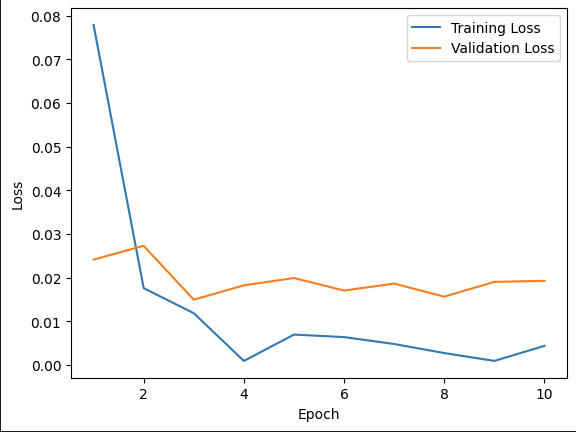

We can see that the model tends towards symptoms of overfitting near epoch 10, where the validation loss no longer decreses noticably, and yet the training loss has significantly decreased. With the model now nearing its optimal training therefore, we can calculate for its dice score against an unseen test set.

In [ ]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    # Floor/Ceil the probabilities to 0 and 1
    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

We now test for its overall performance, as samples and loss alone give little indication of its true capabilities after training, and define the dice coefficient function as sourced from here: https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114. This function, like many implementations of calculating dice, adds a miniscule epsilon to both sides of the final equation. This achieves two things: To prevent division by zero where a correct negative prediction is done, and to reward the network with a dice of 1 for a correct negative evaluation.
We can now apply this function over the testing set to get an average performance over an unseen dataset:

In [ ]:
with torch.no_grad():
    model.eval()
    total_dc = 0
    for images, masks in tqdm(test_data):
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        dc = dice_coefficient(outputs, masks)
        total_dc += dc.item()

    val_dc = total_dc / val_data_count
    print(val_dc)

(Documented in results section)

### 4.2 VNet
VNet is a convolutional neural network which is designed to specially deal with the segmentation of volumetric medical imagery. It operates on the 3D input data from sources such as MRI or CT scans. Using a combination of an encoder which captures the spatial features of the scans, and the decoder which reconstructs the segmentation. The architecture also allows for the usage of connections which skip between the encoder and decoder layers, which allows the presentation of resolution and accuracy. There have been several improvements which can been made on VNet since it’s conception in 2016, which incorporate modern improvements. For this assignment, the following implementation has been used can be found [here]( https://github.com/mattmacy/vnet.pytorch). While several modifications have been made to accommodate the KiTS19 kidney tumour segmentation dataset as well several dependency changes.



In [ ]:
import os

import torch
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import nibabel as nib
import numpy as np

class Batch(Dataset):
    def __init__(self, volumes, segmentations):

        ct_image = torch.stack([t.squeeze(0) for t in volumes])
        seg_image = torch.stack([t.squeeze(0) for t in segmentations])

        self.volumes = ct_image
        self.masks = seg_image

    def __len__(self):
        return len(self.volumes.shape[0])

    def __getitem__(self):
        return self.volumes, self.masks

    def get(self):
        return self.volumes, self.masks

    def getVolume(self) -> torch.Tensor:
        return self.volumes

    def getMask(self) -> torch.Tensor:
        return self.masks

class Image(Dataset):
    def __init__(self, volumes: torch.Tensor, segmentations: torch.Tensor):
        self.volumes = volumes
        self.masks = segmentations

    def __len__(self):
        return len(self.volumes)

    def __getitem__(self):
        return self.volumes, self.masks

    def getVolume(self) -> torch.Tensor:
        return self.volumes

    def getMask(self) -> torch.Tensor:
        return self.masks

# data implementation for the KiTS19 dataset
class KiTS19Dataset(Dataset):
    def __init__(self, data_dir="", split_ratio=0.8, train="true", old=None, batch_size=1):
        if isinstance(old, KiTS19Dataset):
            self.data_dir = old.data_dir
            self.case_ids = old.case_ids
            self.train = old.train;
            self.train_ids = old.train_ids
            self.test_ids = old.test_ids
            self.batch_size = old.batch_size
            # self.entry = old.entry;
        else:
            self.data_dir = data_dir
            self.case_ids = self.get_cases()  # List of case IDs to load
            self.train = train;
            train_ids, test_ids = train_test_split(self.case_ids, train_size=split_ratio, random_state=42)
            self.train_ids = train_ids if train else test_ids
            self.test_ids = test_ids
            self.batch_size = batch_size
            # self.loadset()

    def loadset(self):
        if self.train:
            ids = self.train_ids
        else:
            ids = self.test_ids

        s = list()
        ct_buffer = []
        seg_buffer = []
        for id in ids:
            image = self.load_case_idx(id)
            ct_image = image.getVolume()
            seg_image = image.getMask()

            ct_buffer = ct_buffer + ct_image
            seg_buffer = seg_buffer + seg_image

            start_idx = 0
            while start_idx + self.batch_size <= len(ct_buffer):
                s.append(Batch(ct_buffer[:self.batch_size], seg_buffer[:self.batch_size]))
                del ct_buffer[:self.batch_size]
                del seg_buffer[:self.batch_size]

        self.entry = s

        for idx, i in enumerate(self.entry):
            save_path = os.path.dirname(os.path.abspath(__file__)) + '\\slices\\' + f"slice_{idx}"
            torch.save(i, save_path)

    def __len__(self):
        if self.train:
            return len(self.train_ids)
        else:
            return len(self.test_ids)

    def __getitem__(self, idx):
        data = self.load_case_idx(idx)
        ct_image, seg_image = data.get()

        ct_image = ct_image.unsqueeze(0)
        # print(data)
        # ct_image = data.getVolume()
        # seg_image = data.getMask()

        return ct_image, seg_image

    def load_case_idx(self, case_id: int):
        # Construct the case directory name
        # Format the file name according to the case_id
        file_name = f"slice_{case_id}"
        file_path = os.path.join(self.data_dir, file_name)

        # Check if the file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_name} not found in directory {self.data_dir}.")

        # Load and return the contents of the tensor file
        try:
            data = torch.load(file_path)
            return data
        except Exception as e:
            raise RuntimeError(f"Error loading file {file_name}: {e}")

    def _find_case_files(self):
        """Find all files in the format case_xxxxx.pt and return the list of paths and case numbers."""
        case_files = []
        case_numbers = []
        self.data_dir = os.path.dirname(os.path.dirname(__file__)) + self.data_dir
        print(self.data_dir)
        # Traverse the directory to find files matching the format
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.startswith("slice_"):
                    # Extract case number
                    case_number = file.split("_")[1].split(".")[0]
                    case_files.append(os.path.join(root, file))
                    case_numbers.append(case_number)

        return case_files, case_numbers

    def _check_keys_in_tensor(self, file_path):
        """Check if a tensor file contains 'volumes' and 'segmentations' keys."""
        try:
            data = torch.load(file_path)
            if isinstance(data, dict) and "volumes" in data and "segmentations" in data:
                return True
            return False
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return False

    def get_cases(self):
        """Main function to find case files and check for specific keys."""
        case_files, case_numbers = self._find_case_files()
        print(f"Found {len(case_files)} slice files.")
        full_cases = []
        other_cases = []
        # Check each file for the required keys
        for file_path, case_number in zip(case_files, case_numbers):
            full_cases.append(case_number)
        return full_cases

    def train(self):
        self.train = True;

    def test(self):
        self.train = False;
        # self.entry = self.loadset()

    def target_mean(self):
        if self.train:
            target_ids = self.train_ids
        else:
            target_ids = self.test_ids

        ms = []
        for i in target_ids:
            data = self.load_case_idx(i)
            target = data.getMask()
            ml = []
            for j in target:
                m = np.mean(j.cpu().numpy())
                ml.append(m)

            m = np.mean(ml)
            ms.append(m)
        return np.mean(ms)


# modified code, from https://github.com/mattmacy/vnet.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F


def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)

# normalization between sub-volumes is necessary
# for good performance

class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'
                             .format(input.dim()))

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out

def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)

class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(16)
        self.relu1 = ELUCons(elu, 16)

    def forward(self, x):
        # do we want a PRELU here as well?
        out = self.bn1(self.conv1(x))
        # split input in to 16 channels
        x16 = torch.cat((x, x, x, x, x, x, x, x,
                         x, x, x, x, x, x, x, x), 0)
        out = self.relu1(torch.add(out, x16))
        return out

class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2*inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=1, stride=1)
        self.bn1 = ContBatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=1, stride=1)
        self.bn1 = ContBatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, 2, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 2, kernel_size=1)
        self.relu1 = ELUCons(elu, 2)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        # convolve 32 down to 2 channels
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        # make channels the last axis
        out = out.permute(0, 2, 3, 4, 1).contiguous()
        # flatten
        out = out.view(out.numel() // 2, 2)
        out = self.softmax(out)
        # treat channel 0 as the predicted output
        return out


class VNet(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll)

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out

import time
import argparse
import torch

import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from tools.dataset import KiTS19Dataset

import tools.loss as bioloss
import tools.bioutlis as utils

from torch.cuda.amp import GradScaler, autocast

import os
import sys
import math

import shutil

import setproctitle

from functools import reduce
import operator

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.kaiming_normal(m.weight)
        m.bias.data.zero_()

def datestr():
    now = time.gmtime()
    return '{}{:02}{:02}_{:02}{:02}'.format(now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)


def save_checkpoint(state, is_best, path, prefix, filename='checkpoint.pth.tar'):
    prefix_save = os.path.join(path, prefix)
    name = prefix_save + '_' + filename
    torch.save(state, name)
    if is_best:
        shutil.copyfile(name, prefix_save + '_model_best.pth.tar')


def inference(args, loader, model, transforms):
    src = args.inference
    dst = args.save

    model.eval()
    nvols = reduce(operator.mul, target_split, 1)
    # assume single GPU / batch size 1
    for data in loader:
        data, series, origin, spacing = data[0]
        shape = data.size()
        # convert names to batch tensor
        if args.cuda:
            data.pin_memory()
            data = data.cuda()
        data = Variable(data, volatile=True)
        output = model(data)
        _, output = output.max(1)
        output = output.view(shape)
        output = output.cpu()
        # merge subvolumes and save
        results = output.chunk(nvols)
        results = map(lambda var : torch.squeeze(var.data).numpy().astype(np.int16), results)
        volume = utils.merge_image([*results], target_split)
        print("save {}".format(series))
        utils.save_updated_image(volume, os.path.join(dst, series + ".mhd"), origin, spacing)

# performing post-train inference:
# train.py --resume <model checkpoint> --i <input directory (*.mhd)> --save <output directory>

def noop(x):
    return x

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--batchSz', type=int, default=1)
    parser.add_argument('--dice', action='store_true')
    parser.add_argument('--ngpu', type=int, default=1)
    parser.add_argument('--nEpochs', type=int, default=300)
    parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                        help='evaluate model on validation set')
    parser.add_argument('-i', '--inference', default='', type=str, metavar='PATH',
                        help='run inference on data set and save results')

    # 1e-8 works well for lung masks but seems to prevent
    # rapid learning for nodule masks
    parser.add_argument('--weight-decay', '--wd', default=1e-8, type=float,
                        metavar='W', help='weight decay (default: 1e-8)')
    parser.add_argument('--no-cuda', action='store_true')
    parser.add_argument('--save')
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--opt', type=str, default='adam',
                        choices=('sgd', 'adam', 'rmsprop'))
    args = parser.parse_args()
    best_prec1 = 100.
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    args.save = args.save or 'work/vnet.base.{}'.format(datestr())
    nll = True
    if args.dice:
        nll = False
    weight_decay = args.weight_decay
    setproctitle.setproctitle(args.save)

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    print("build vnet")
    model = vnet.VNet(elu=False, nll=nll)
    batch_size = args.ngpu*args.batchSz
    gpu_ids = range(args.ngpu)
    model = nn.parallel.DataParallel(model, device_ids=gpu_ids)

    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.evaluate, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))
    else:
        model.apply(weights_init)

    if nll:
        train = train_nll
        test = test_nll
        class_balance = True
    else:
        train = train_dice
        test = test_dice
        class_balance = False

    print('  + Number of params: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))
    if args.cuda:
        model = model.cuda()

    if os.path.exists(args.save):
        shutil.rmtree(args.save)
    os.makedirs(args.save, exist_ok=True)

    # LUNA16 dataset isotropically scaled to 2.5mm^3
    # and then truncated or zero-padded to 160x128x160
    normMu = [-642.794]
    normSigma = [459.512]
    normTransform = transforms.Normalize(normMu, normSigma)

    trainTransform = transforms.Compose([
        transforms.ToTensor(),
        normTransform
    ])
    testTransform = transforms.Compose([
        transforms.ToTensor(),
        normTransform
    ])
    if ct_targets == nodule_masks:
        masks = lung_masks
    else:
        masks = None

    if args.inference != '':
        if not args.resume:
            print("args.resume must be set to do inference")
            exit(1)
        kwargs = {'num_workers': 1} if args.cuda else {}
        src = args.inference
        dst = args.save
        inference_batch_size = args.ngpu
        root = os.path.dirname(src)
        images = os.path.basename(src)
        dataset = KiTS19Dataset(data_dir="\p_data")
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=noop, **kwargs)
        inference(args, loader, model, trainTransform)
        return

    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    print("loading training set")
    trainSet = KiTS19Dataset(data_dir="\slices")
    trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=True, **kwargs)
    print("loading test set")
    testSet = KiTS19Dataset(old=trainSet)
    testSet.test()
    testLoader = DataLoader(testSet,batch_size=batch_size, shuffle=False, **kwargs)

    target_mean = trainSet.target_mean()
    bg_weight = target_mean / (1. + target_mean)
    fg_weight = 1. - bg_weight
    # print(bg_weight)
    class_weights = torch.FloatTensor([bg_weight, fg_weight])


    if args.cuda:
        class_weights = class_weights.cuda()

    if args.opt == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=1e-1,
                              momentum=0.99, weight_decay=weight_decay)
    elif args.opt == 'adam':
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), weight_decay=weight_decay)

    trainF = open(os.path.join(args.save, 'train.csv'), 'w')
    testF = open(os.path.join(args.save, 'test.csv'), 'w')
    err_best = 100.
    for epoch in range(1, args.nEpochs + 1):
        adjust_opt(args.opt, optimizer, epoch)
        train(args, epoch, model, trainLoader, optimizer, trainF, class_weights)
        err = test(args, epoch, model, testLoader, optimizer, testF, class_weights)
        is_best = False
        if err < best_prec1:
            is_best = True
            best_prec1 = err
        save_checkpoint({'epoch': epoch,
                         'state_dict': model.state_dict(),
                         'best_prec1': best_prec1},
                        is_best, args.save, "vnet")
        os.system('./plot.py {} {} &'.format(len(trainLoader), args.save))

    trainF.close()
    testF.close()


def train_nll(args, epoch, model, trainLoader, optimizer, trainF, weights):
    model.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    for batch_idx, (data, target) in enumerate(trainLoader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        target = target.view(target.numel())
        loss = F.nll_loss(output, target, weight=weights)
        dice_loss = bioloss.dice_error(output, target)
        # make_graph.save('/tmp/t.dot', loss.creator); assert(False)
        loss.backward()
        optimizer.step()
        nProcessed += len(data)
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        incorrect = pred.ne(target.data).cpu().sum()
        err = 100.*incorrect/target.numel()
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tError: {:.3f}\t Dice: {:.6f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.data[0], err, dice_loss))

        trainF.write('{},{},{}\n'.format(partialEpoch, loss.data[0], err))
        trainF.flush()

def test_nll(args, epoch, model, testLoader, optimizer, testF, weights):
    model.eval()
    test_loss = 0
    dice_loss = 0
    incorrect = 0
    numel = 0
    for data, target in testLoader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        target = target.view(target.numel())
        numel += target.numel()
        output = model(data)
        test_loss += F.nll_loss(output, target, weight=weights).data[0]
        dice_loss += bioloss.dice_error(output, target)
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        incorrect += pred.ne(target.data).cpu().sum()

    test_loss /= len(testLoader)  # loss function already averages over batch size
    dice_loss /= len(testLoader)
    err = 100.*incorrect/numel
    print('\nTest set: Average loss: {:.4f}, Error: {}/{} ({:.3f}%) Dice: {:.6f}\n'.format(
        test_loss, incorrect, numel, err, dice_loss))

    testF.write('{},{},{}\n'.format(epoch, test_loss, err))
    testF.flush()
    return err


def train_dice(args, epoch, model, trainLoader, optimizer, trainF, weights):
    model.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    scaler = GradScaler()

    for batch_idx, (data, target) in enumerate(trainLoader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        with autocast():
            data = data.permute(1, 2, 0, 3, 4)
            target = target.permute(1, 0, 2, 3)

            output = model(data)
            loss = bioloss.dice_loss(output, target)
        make_graph.save('/tmp/t.dot', loss.creator); assert(False)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        nProcessed += len(data)
        err = 100.*(1. - loss.data[0])
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.8f}\tError: {:.8f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.data[0], err))

        trainF.write('{},{},{}\n'.format(partialEpoch, loss.data[0], err))
        trainF.flush()


def test_dice(args, epoch, model, testLoader, optimizer, testF, weights):
    model.eval()
    test_loss = 0
    incorrect = 0
    scaler = GradScaler()

    with torch.no_grad():
        for data, target in testLoader:
            if args.cuda:
                data, target = data.cuda(), target.cuda()

            with autocast():
                data = data.permute(1, 2, 0, 3, 4)
                target = target.permute(1, 0, 2, 3)

                output = model(data)
                loss = bioloss.dice_loss(output, target)


            test_loss += loss
            incorrect += (1. - loss)

    test_loss /= len(testLoader)  # loss function already averages over batch size
    nTotal = len(testLoader)
    err = 100.*incorrect/nTotal
    print('\nTest set: Average Dice Coeff: {:.4f}, Error: {}/{} ({:.0f}%)\n'.format(
        test_loss, incorrect, nTotal, err))

    testF.write('{},{},{}\n'.format(epoch, test_loss, err))
    testF.flush()
    return err


def adjust_opt(optAlg, optimizer, epoch):
    if optAlg == 'sgd':
        if epoch < 150:
            lr = 1e-1
        elif epoch == 150:
            lr = 1e-2
        elif epoch == 225:
            lr = 1e-3
        else:
            return

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr



Running the train.py file, enables the training loop to run, and generate results as below
```
python3 train.py --dice --save \save
```


### 4.3 SAMNet
SAMNet is a specialised network created by Meta (the parent company of Facebook) for image segmentation in complex situations. It performs very well across a large and generalised scope of various segmentation tasks from medical imagery segmentation to “cutting out” subjects from images. The architecture differs vastly from the previous solutions combining convolutional layers with transformer-based attention mechanism to provide both localised detail and global context. This model has been pre-trained and several milestones have been made available to be used, while retraining using the KiTS19 dataset.

The SAMNet output masks were then fed into an additional fully connected Keras Nerual Network with the objective to predict which mask in the slice would produce the highest DICE score. This neural network used the leaky ReLU activation and was trained using early stopping to prevent over fitting. The full pipeline for prediction was then as follows;
1. Feed the image into SAMNet to decompose it into around 20 different potential kidney masks.
2. Pass through information about each mask into the custom fully connected neural net to recieve DICE Score predictions.
3. Combine the two masks with the highest predicted DICE scores in each slice forming a final prediction segmentation.

While at first only a single mask was used for prediction, it was found that combining the best two masks together produced more accurate results. We believe this is a consequence of having two distinct and separated kidneys with SAMNet producing seperate masks for each.



In [ ]:
# SAMNet Imports
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
import joblib

from starter_code.utils import load_case
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

from keras.models import Sequential, load_model
from keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
# SAMNet Helper functions

# Changes the format of flat b&w image slices so that they can be processed by SAMnet
def to_rgb(img):
    img_rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=img.dtype)
    img_rgb[:, :, 0] = img
    img_rgb[:, :, 1] = img
    img_rgb[:, :, 2] = img
    return img_rgb

# Calculate the DICE Score between two images
def dice_coefficient(img1, img2):
    intersection = np.logical_and(img1, img2)
    return (2. * intersection.sum())  / (img1.sum() + img2.sum())

# Given an array, finds the index of the largest element
def find_max(arr):
  highest_index = 0
  for i in range(1, len(arr)):
    if arr[i] > arr[highest_index]:
      highest_index = i
  return highest_index

The following code was used to load the images, and generate masks forming the test data. Specifically a matrix containing each masks size, location and stability was formed and its dice coefficient was recorded to be used as target variables.

Importantly, not all the slices in the dataset contain kidneys, however to prevent our neural network from learning that an empty mask is most likely to be a kidney, only slices with kidneys were passed through into the training set. This will allow our algorithm to actually detect what a kidney looks like.

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
# The "sam_vit_h_4b8939.pth" file must be downloaded from Meta's SAMNet repo;
# https://github.com/facebookresearch/segment-anything/tree/main

ITERATIONS = 200

# Create the automatic mask generator
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

x = np.empty((0, 9))
y = np.empty((0))

# Randomly selected cases and slices were chosen from the allocated training region
# of the dataset. From each slice the characteristics of the masks were fed into an input
# matrix and the corresponding DICE score of the mask fed into an output vector.
for i in range(ITERATIONS):
  print(f"Progress: {i+1}/{ITERATIONS}, ({(i+1)/ITERATIONS}%)")
  case_index = random.randint(0, 159)

  volume, segmentation = load_case("case_00{:03d}".format(case_index))
  volume_data = volume.get_fdata()
  seg_data = segmentation.get_fdata()

  c = 0
  while (c == 0):
      # Load data
      slice_index = random.randint(0, len(volume_data)-1)

      volume_slice = volume_data[slice_index, :, :]
      seg_slice = seg_data[slice_index, :, :]

      # Ensures slice has a kidney in it for training.
      kidney_mask = (seg_slice == 1).astype(np.uint8)
      if not (np.all(kidney_mask == 0)):
          c = 1

  # Convert image to rgb
  vol_rgb = to_rgb(volume_slice)

  # Generate masks
  masks = mask_generator.generate(vol_rgb)

  # Create X matrix for neural net
  for mask in masks:
    mask_data = np.array(mask['segmentation'])
    y = np.append(y, dice_coefficient(kidney_mask, mask_data))

    data = np.array([mask['area'], mask['bbox'][0], mask['bbox'][1], mask['bbox'][2], mask['bbox'][3],
                  mask['predicted_iou'], mask['point_coords'][0][0], mask['point_coords'][0][1], mask['stability_score']])
    x = np.vstack((x, data))

  # np.save('trainingMatrix.npy', x)
  # np.save('trainingTarget.npy', y)


The following code trains a simple fully connected network using Keras. Early stopping was used to prevent overfitting and a scaler was applied to the input data to ensure features had equal initial weighting. The training ended after 180 epochs. The model and scaler were saved so that they wouldn't have to be retrained each time.

In [ ]:
# x = np.load('./trainingMatrix.npy')
# y = np.load('./trainingTarget.npy')

# Create a randomly selected validation set
X_train, X_val, y_train, y_val = train_test_split(
    x, y, random_state=31)

scaler = StandardScaler()
scaler.fit(X_train)

x_sc = scaler.transform(X_train)
x_val_sc = scaler.transform(X_val)

random.seed(31)

model = Sequential([
    Dense(32, activation="leaky_relu"),
    Dense(8, activation="leaky_relu"),
    Dense(1, activation="exponential")
])
model.compile("adam", "mse")

es = EarlyStopping(restore_best_weights=True, patience=35)

%time hist = model.fit(x_sc, y_train, epochs=1_000, \
    callbacks=[es], validation_data=(x_val_sc, y_val))

# Plot a graph of the validation loss over the training
plt.plot(range(1, 181), hist.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE");

# Save the model and scaler to avoid retraining
model.save('/kidney_model.keras')

scaler_filename = "my_scaler.save"
joblib.dump(scaler, scaler_filename)

scaler = joblib.load("my_scaler.save")

Validation Loss when learning to predict DICE Scores;

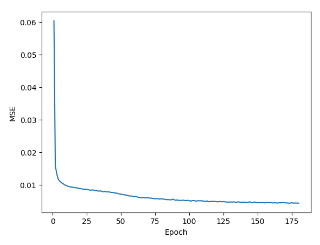

Next, test data was processed in a similar fashion to the training set. The data is stored slightly differently with each mask being saved next to the target kidney mask. This is for convencience for identifying which slice the mask belongs to, comparing the accuracy of each mask and combining masks individual masks together. Otherwise the input matrix is identically structured to the training data.

In [ ]:
x_test = np.empty((0, 9))
imgs = []

# Generate test data from final 50 cases
# Test data includes a numerical matrix (x_test) in addition to the image for each mask paired with its corresponding target kidney mask (imgs)
for i in range(161,209):
  print(f"Case: {i}")

  volume, segmentation = load_case("case_00{:03d}".format(i))
  volume_data = volume.get_fdata()
  seg_data = segmentation.get_fdata()

  for j in range(len(volume_data)):
    print(f"Slice: {j}")
    volume_slice = volume_data[j, :, :]
    seg_slice = seg_data[j, :, :]
    kidney_mask = (seg_slice == 1).astype(np.uint8)

    # Convert image to rgb
    vol_rgb = to_rgb(volume_slice)

    # Generate masks
    masks = mask_generator.generate(vol_rgb)

    # Create X matrix for neural net
    for mask in masks:
      mask_data = np.array(mask['segmentation'])
      img = np.array([mask_data, kidney_mask])
      imgs.append(img)

      data = np.array([mask['area'], mask['bbox'][0], mask['bbox'][1], mask['bbox'][2], mask['bbox'][3],
                    mask['predicted_iou'], mask['point_coords'][0][0], mask['point_coords'][0][1], mask['stability_score']])
      x_test = np.vstack((x_test, data))
      imgs_np = np.stack(imgs)
      # np.save('testMatrix.npy', x_test)
      # np.save('imgMatrix.npy', imgs_np)


Finally, the test input matrix was fed into the trained model and predcited DICE Scores were produced. For each slice, the highest scoring mask was used as a prediction for the kidney segmentation. Afterwards the two highest scoring masks were combined for an alternative prediction.
This method of combining the two best masks together significantly improved the accuracy of the model as measured by each predictions DICE Score with the actual segmentation.

In [ ]:
# x_test = np.load('./testMatrix.npy')
# imgs_np = np.load('drive/MyDrive/imgMatrix.npy')

model = load_model('./kidney_model.keras')
scaler = joblib.load("my_scaler.save")

# Ensuring test input is preprocessed the same way as training input
x_test_sc = scaler.transform(x_test)

y_pred = np.zeros(len(x_test_sc))
for i in range(len(x_test_sc)):
    x1 = x_test_sc[i]
    x1 = x1.reshape(1, -1)
    y_pred[i] = model.predict(x1, verbose=0)

# Visualise most kidney predicted mask from entire set (252)
v = imgs_np[find_max(y_pred)][0]
plt.figure(figsize=(5, 5))
plt.imshow(v, cmap='gray')
plt.title('Volume Image Slice')
plt.axis('off')
plt.show()

# Group masks by which case/slice they represent
j = 0
slice_index = np.zeros(len(y_pred) - 1)
for i in range(y_pred.shape[0] - 1):
    if i != 0 and not np.array_equal(imgs_np[i][1], imgs_np[i-1][1]):
        j += 1
    slice_index[i] = j

# For each slice, find mask with highest predicted dice score
max_dice = np.zeros((j+1, 2))
for i in range(y_pred.shape[0] - 1):
    if max_dice[int(slice_index[i])][0] < y_pred[i]:
        max_dice[int(slice_index[i])][0] = y_pred[i]
        max_dice[int(slice_index[i])][1] = i

# Determine actual dice score using this mask
one_mask_result = np.zeros(j+1)
for k in range(j+1):
    one_mask_result[k] = dice_coefficient(imgs_np[int(max_dice[k][1])][0], imgs_np[int(max_dice[k][1])][1])

print(np.mean(one_mask_result))

# For each slice, find mask with second highest predicted dice score
max_dice2 = np.zeros((j+1, 2))
for i in range(y_pred.shape[0] - 1):
    if max_dice2[int(slice_index[i])][0] < y_pred[i] and i != max_dice[int(slice_index[i])][1]:
        max_dice2[int(slice_index[i])][0] = y_pred[i]
        max_dice2[int(slice_index[i])][1] = i

# Combine top two masks as there are usually two kidneys (improves accuracy)
two_mask_result = np.zeros(j+1)
for k in range(j+1):
    combined_mask = np.logical_or(imgs_np[int(max_dice[k][1])][0], imgs_np[int(max_dice2[k][1])][0])
    two_mask_result[k] = dice_coefficient(combined_mask, imgs_np[int(max_dice2[k][1])][1])

print(np.mean(two_mask_result))

### 4.4 nnU-Net
nnU-Net or known as “no-new-Net” is a framework designed to dynamically adjust itself to any new segmentation task that requires little to no manual intervention. The architecture extends that of the original UNet via the integration of preprocessing, flexible architecture design, and a post-processing pipeline. It can adjust by using 2D, 3D and cascaded segmentation to automatically choose the best approach for the specific dataset. Due to the flexibility and generalisation continually achieves high performance for medical segmentation results.

Because of this "no-frills" approach to semantic segmentation, our group decided to spend our time getting nnUNet to work. We begun by training locally:

Taking this (original) directory structure

```
data
├── case_00000
│   ├── imaging.nii.gz
│   └── segmentation.nii.gz
├── case_00001
│   ├── imaging.nii.gz
│   └── segmentation.nii.gz
...
├── case_00298
│   └── imaging.nii.gz
├── case_00299
│   └── imaging.nii.gz
├── kits.json
└── LICENSE
```

and transforming it via a bash/sed/awk script to the following nnUNet compliant directory structure

```
├── nnUNet_raw
│   └── Dataset001_Kits19
│       ├── dataset.json
│       ├── imagesTr
│       │   ├── imaging_000_0000.nii.gz
│       │   ├── imaging_001_0000.nii.gz
│       │   ├── imaging_002_0000.nii.gz
│       │   ├── imaging_003_0000.nii.gz
│       │   └── imaging_004_0000.nii.gz
|       |   └── ...
│       ├── imagesTs
│       └── labelsTr
│           ├── imaging_000.nii.gz
│           ├── imaging_001.nii.gz
│           ├── imaging_002.nii.gz
│           ├── imaging_003.nii.gz
│           └── imaging_004.nii.gz
|           └── ...
```

We then solved environment dependencies (nnUNetv2 is only available via pip). Here is the link to the [github](https://github.com/MIC-DKFZ/nnUNet). We spent a long time in the `./documentation` directory.

Once all the environmental variables were set, and torch was configured correctly to find our **GPU**, we ran the following command:

In [ ]:
nnUNetv2_plan_and_preprocess -d 1 --verify_dataset_integrity

The above command populates the `nnUNet_preprocessed` directory with `.pkl` files along with `.npz` files and even just straight up `.npy` files.

These files are the uncompressed representations of the CT scans from the original `imaging.nii.gz`/`segmentation.nii.gz` files.



Since there is not a lot going on, we can take a second to understand all of what is:

The `--verify_dataset_integrity` flag makes sure everything is correct. I.e. it ensures the number of training samples in the directories are exactly the same number you promised in the `dataset.json` file.

Furthermore, this flag checks file formats, file labels and image dimensions within those files. It also checks for corrupted training data.

The `-d 1` flag, refers to the `Dataset001_Kits19` directory, where this is the number 1 dataset (recall that nnUNet stands for no-new-UNet, and is intended to be a general purpose solver for all of your semantic segmentation needs).

Ultimately, the output of this (automated!) preprocessing step is:

It might also be worth quickly explaining the transformation of file names:

In the __nnUNet__ file structure anything in the `labelsTr` directory is understood to be a segmentation mask; as such we no longer have to label it with _segmentation_ in the filename. Also, the triple-padded integer represents the case-number, whilst the four-padded integer represents the "channel" being used. In our case, we only had the single channel, so all files had the `0000` suffix.

Here is what the `bash` file looked like

In [ ]:
#!/bin/bash

# create target directories if they don't exist
mkdir -p ./Dataset001_Kits19/imagesTr
mkdir -p ./Dataset001_Kits19/labelsTr

# all cases
for case_dir in ./data/case_*; do
  # extract the case number. remove leading zeros
  case_num=$(echo "$case_dir" | awk -F'_' '{print $2}' | sed 's/^0*//')

  # pad
  case_num_padded=$(printf "%03d" "$case_num")

  # cp, maybe mv?
  imaging_file="${case_dir}/imaging.nii.gz"
  if [[ -f "$imaging_file" ]]; then
    cp -v "$imaging_file" "./Dataset001_Kits19/imagesTr/imaging_${case_num_padded}_0000.nii.gz"
  else
    echo "error: no img file for: $case_num_padded"
  fi

  # seg file
  segmentation_file="${case_dir}/segmentation.nii.gz"
  if [[ -f "$segmentation_file" ]]; then
    cp -v "$segmentation_file" "./Dataset001_Kits19/labelsTr/imaging_${case_num_padded}.nii.gz"
  else
    echo "no seg files for ya boy: $case_num_padded"
  fi
done

echo "yeehaw"


```
z5362216@katana3:.../nnUNet_preprocessed/Dataset001_Kits19 $ tree -L 1
.
├── dataset_fingerprint.json
├── dataset.json
├── gt_segmentations
├── nnUNetPlans_2d
├── nnUNetPlans_3d_fullres
├── nnUNetPlans_3d_lowres
├── nnUNetPlans.json
└── splits_final.json

4 directories, 4 files
```

Ignoring, the above login for *katana* (foreshadowing), we see that all the hyper-parameters that we were originally frustrated about have now been automatically determined:
- which normalisation methods to use, on image, mask or both?
- range for HU
- size of kernels
- how many convolutional layers
- voxel spacing?

Beyond, pure laziness, we chose this approach not to abstract away the complexity and control of Deep Learning and UNet, but rather because these hyperparameters will change _vastly_ for greatly similar problems:
- spinal vertebrae segmentation
- brain tumour segmentation
- lung nodule detection
- etc.

As such, instead of manually tweaking learning rates and the like, we allowed ourselves to learn and leverage nnUNet (along, later with Katana), to produce a good, honest and __reproducible__ baseline Dice score for the Kits19 challenge.

Moving forward to the training command, we started with training the network on 5 training samples with the 2D model:

In [ ]:
nnUNetv2_train 1 2d 0

`nnUNetv2_train` the command stem
`1` the `./Dataset001_Kits` directory to use
`2d` the model
`0` the fold

We actually, extended this slightly to run 5 fold cross-validation by wrapping the above command in a `for` loop.

In [ ]:
for fold in {0..4}; do nnUNetv2_train 1 2d $fold ; done

The results were: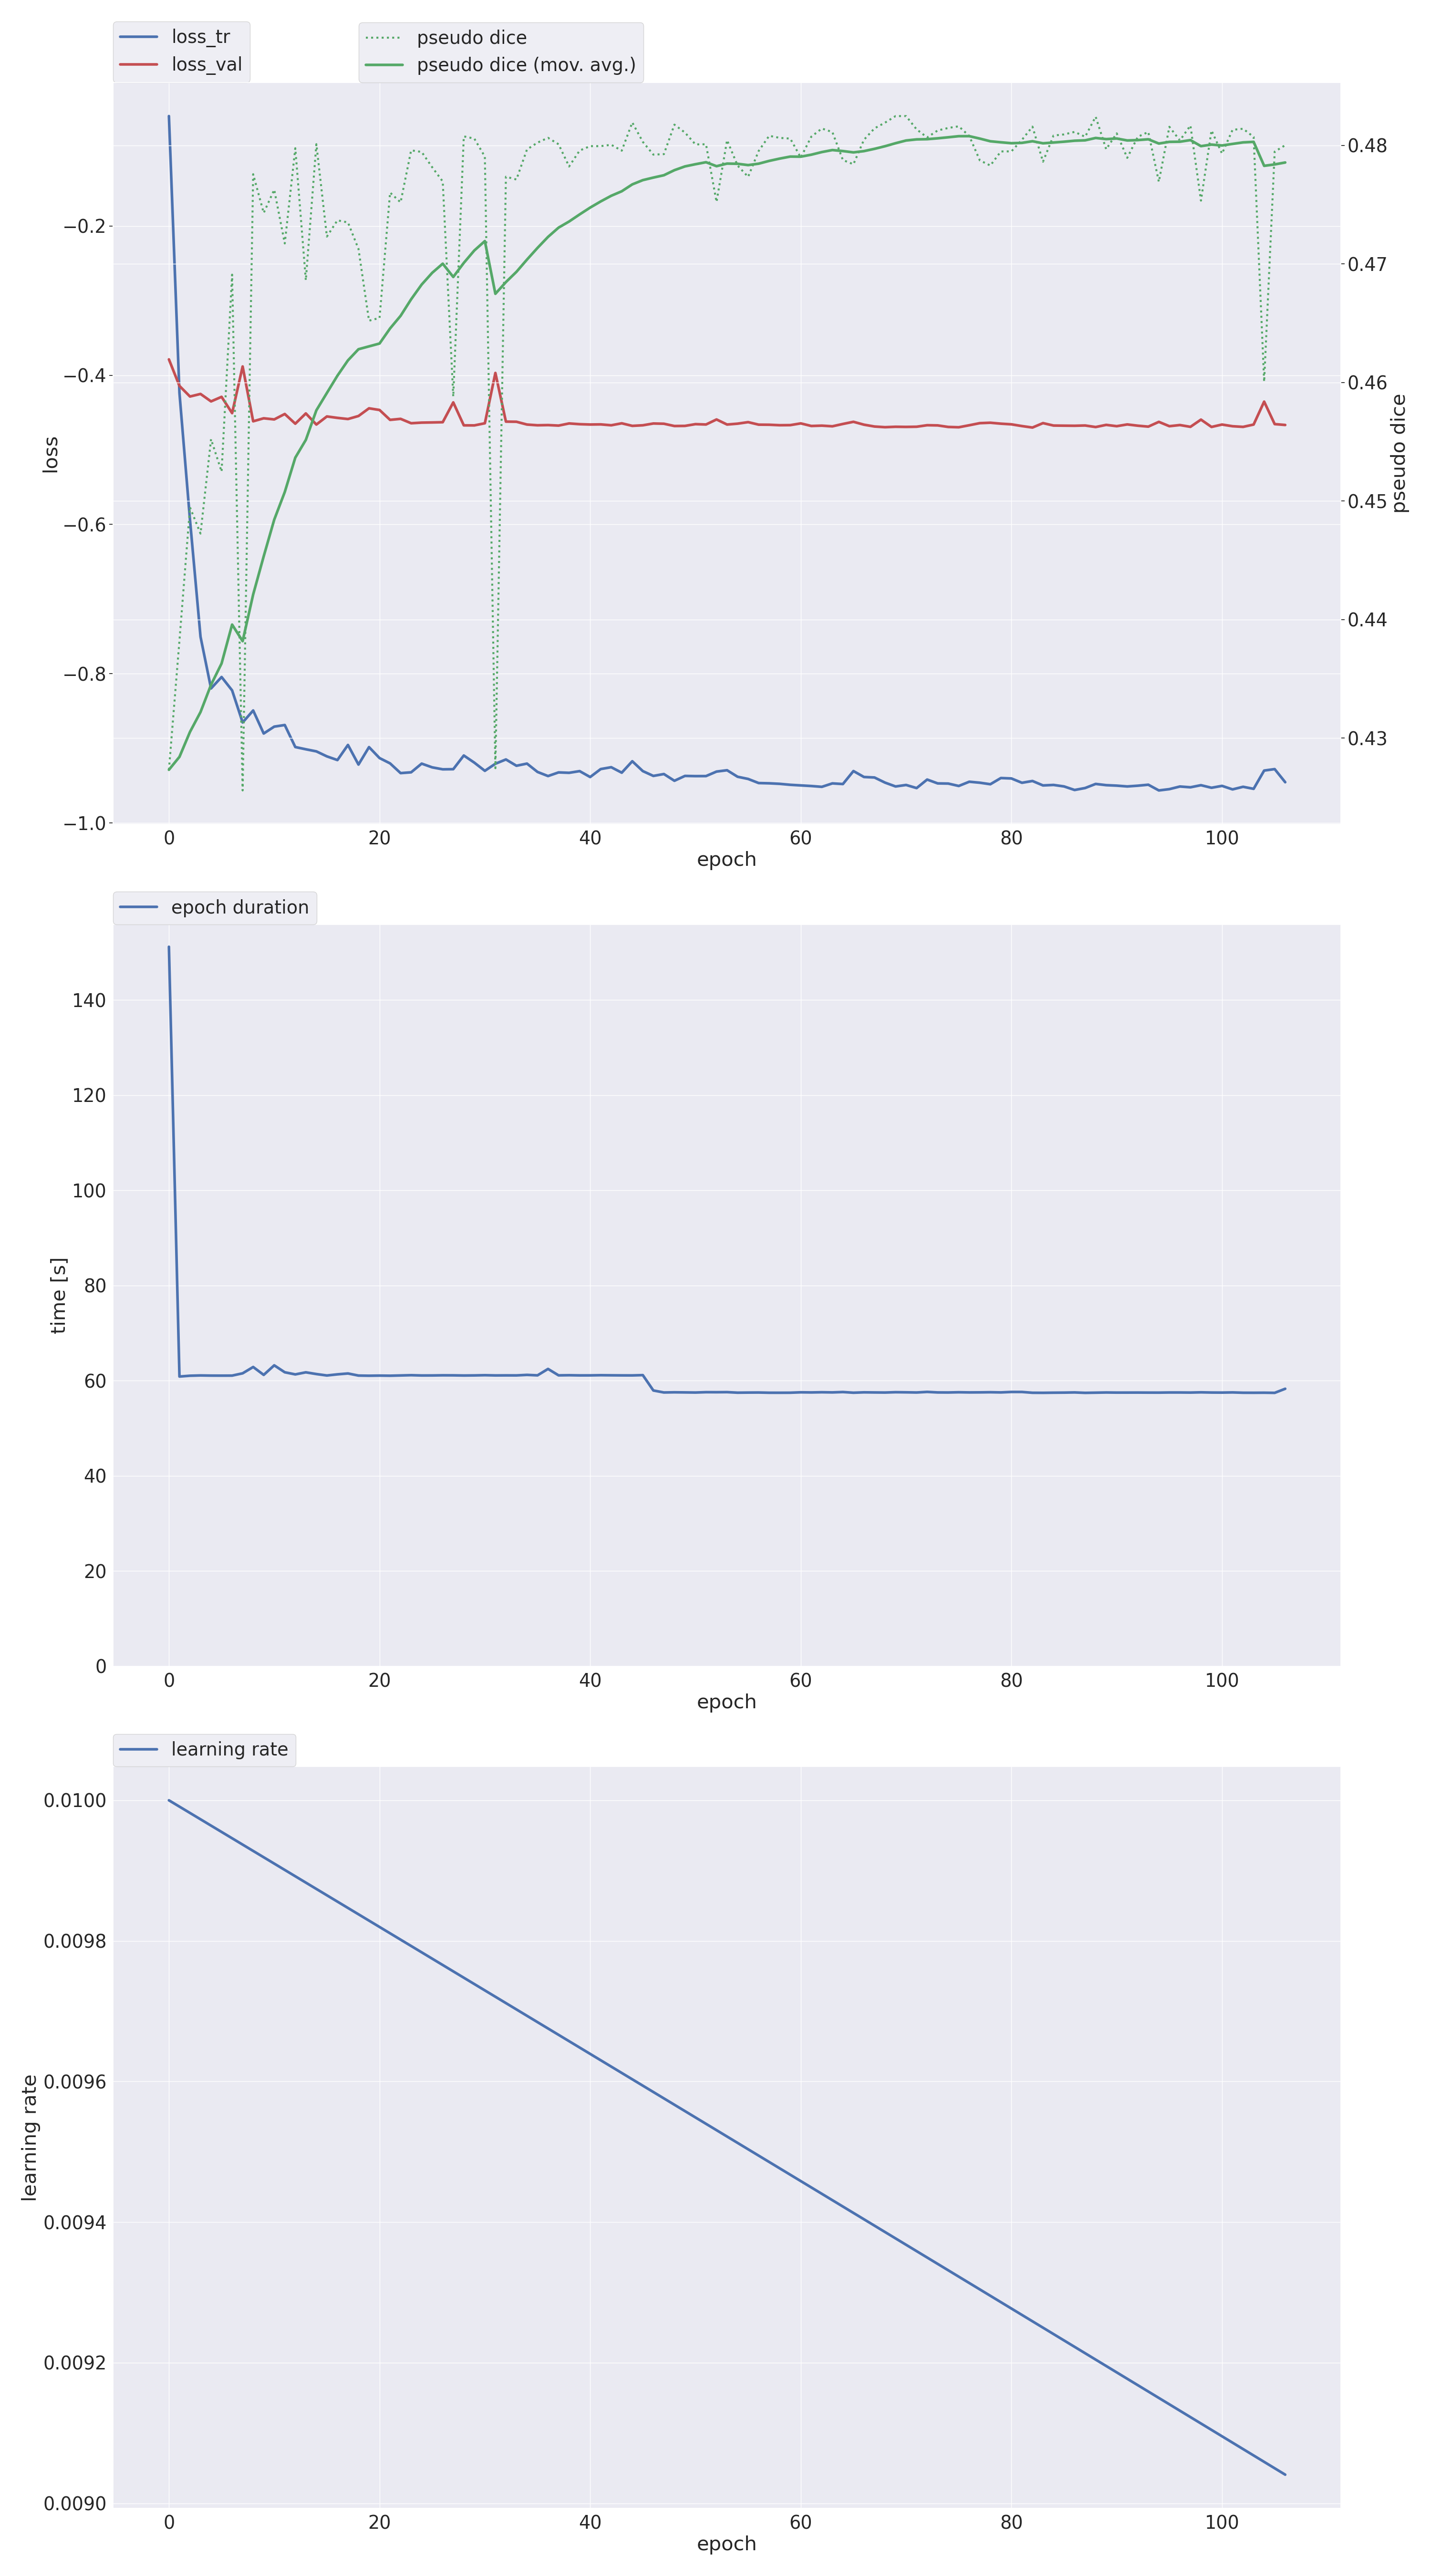

Weird right? Where are the other 4 images? Well you see, on my humble hardware
```
❯ neofetch
            .-/+oossssoo+/-.               alex@bucephalus-desktop
        `:+ssssssssssssssssss+:`           -----------------------
      -+ssssssssssssssssssyyssss+-         OS: Ubuntu 24.04.1 LTS x86_64
    .ossssssssssssssssssdMMMNysssso.       Kernel: 6.8.0-48-generic
   /ssssssssssshdmmNNmmyNMMMMhssssss/      Uptime: 1 hour, 28 mins
  +ssssssssshmydMMMMMMMNddddyssssssss+     Packages: 2736 (dpkg), 26 (snap)
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/    Shell: zsh 5.9
.ssssssssdMMMNhsssssssssshNMMMdssssssss.   Resolution: 3840x2160, 1080x1920
+sssshhhyNMMNyssssssssssssyNMMMysssssss+   WM: i3
ossyNMMMNyMMhsssssssssssssshmmmhssssssso   Theme: Adwaita [GTK3]
ossyNMMMNyMMhsssssssssssssshmmmhssssssso   Icons: Adwaita [GTK3]
+sssshhhyNMMNyssssssssssssyNMMMysssssss+   Terminal: tmux
.ssssssssdMMMNhsssssssssshNMMMdssssssss.   CPU: Genuine Intel 0000 (20) @ 4.700GHz
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/    GPU: NVIDIA GeForce RTX 3070 Ti
  +sssssssssdmydMMMMMMMMddddyssssssss+     Memory: 4526MiB / 31981MiB
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
```

We were unable to train up to 1000 epochs on even the single fold, let alone 1000 epochs on all five folds.

Our tutor informed us about **Katana**, UNSW's High Powered Computing, and for the past 6 days we have been training our model there. Here are our results:

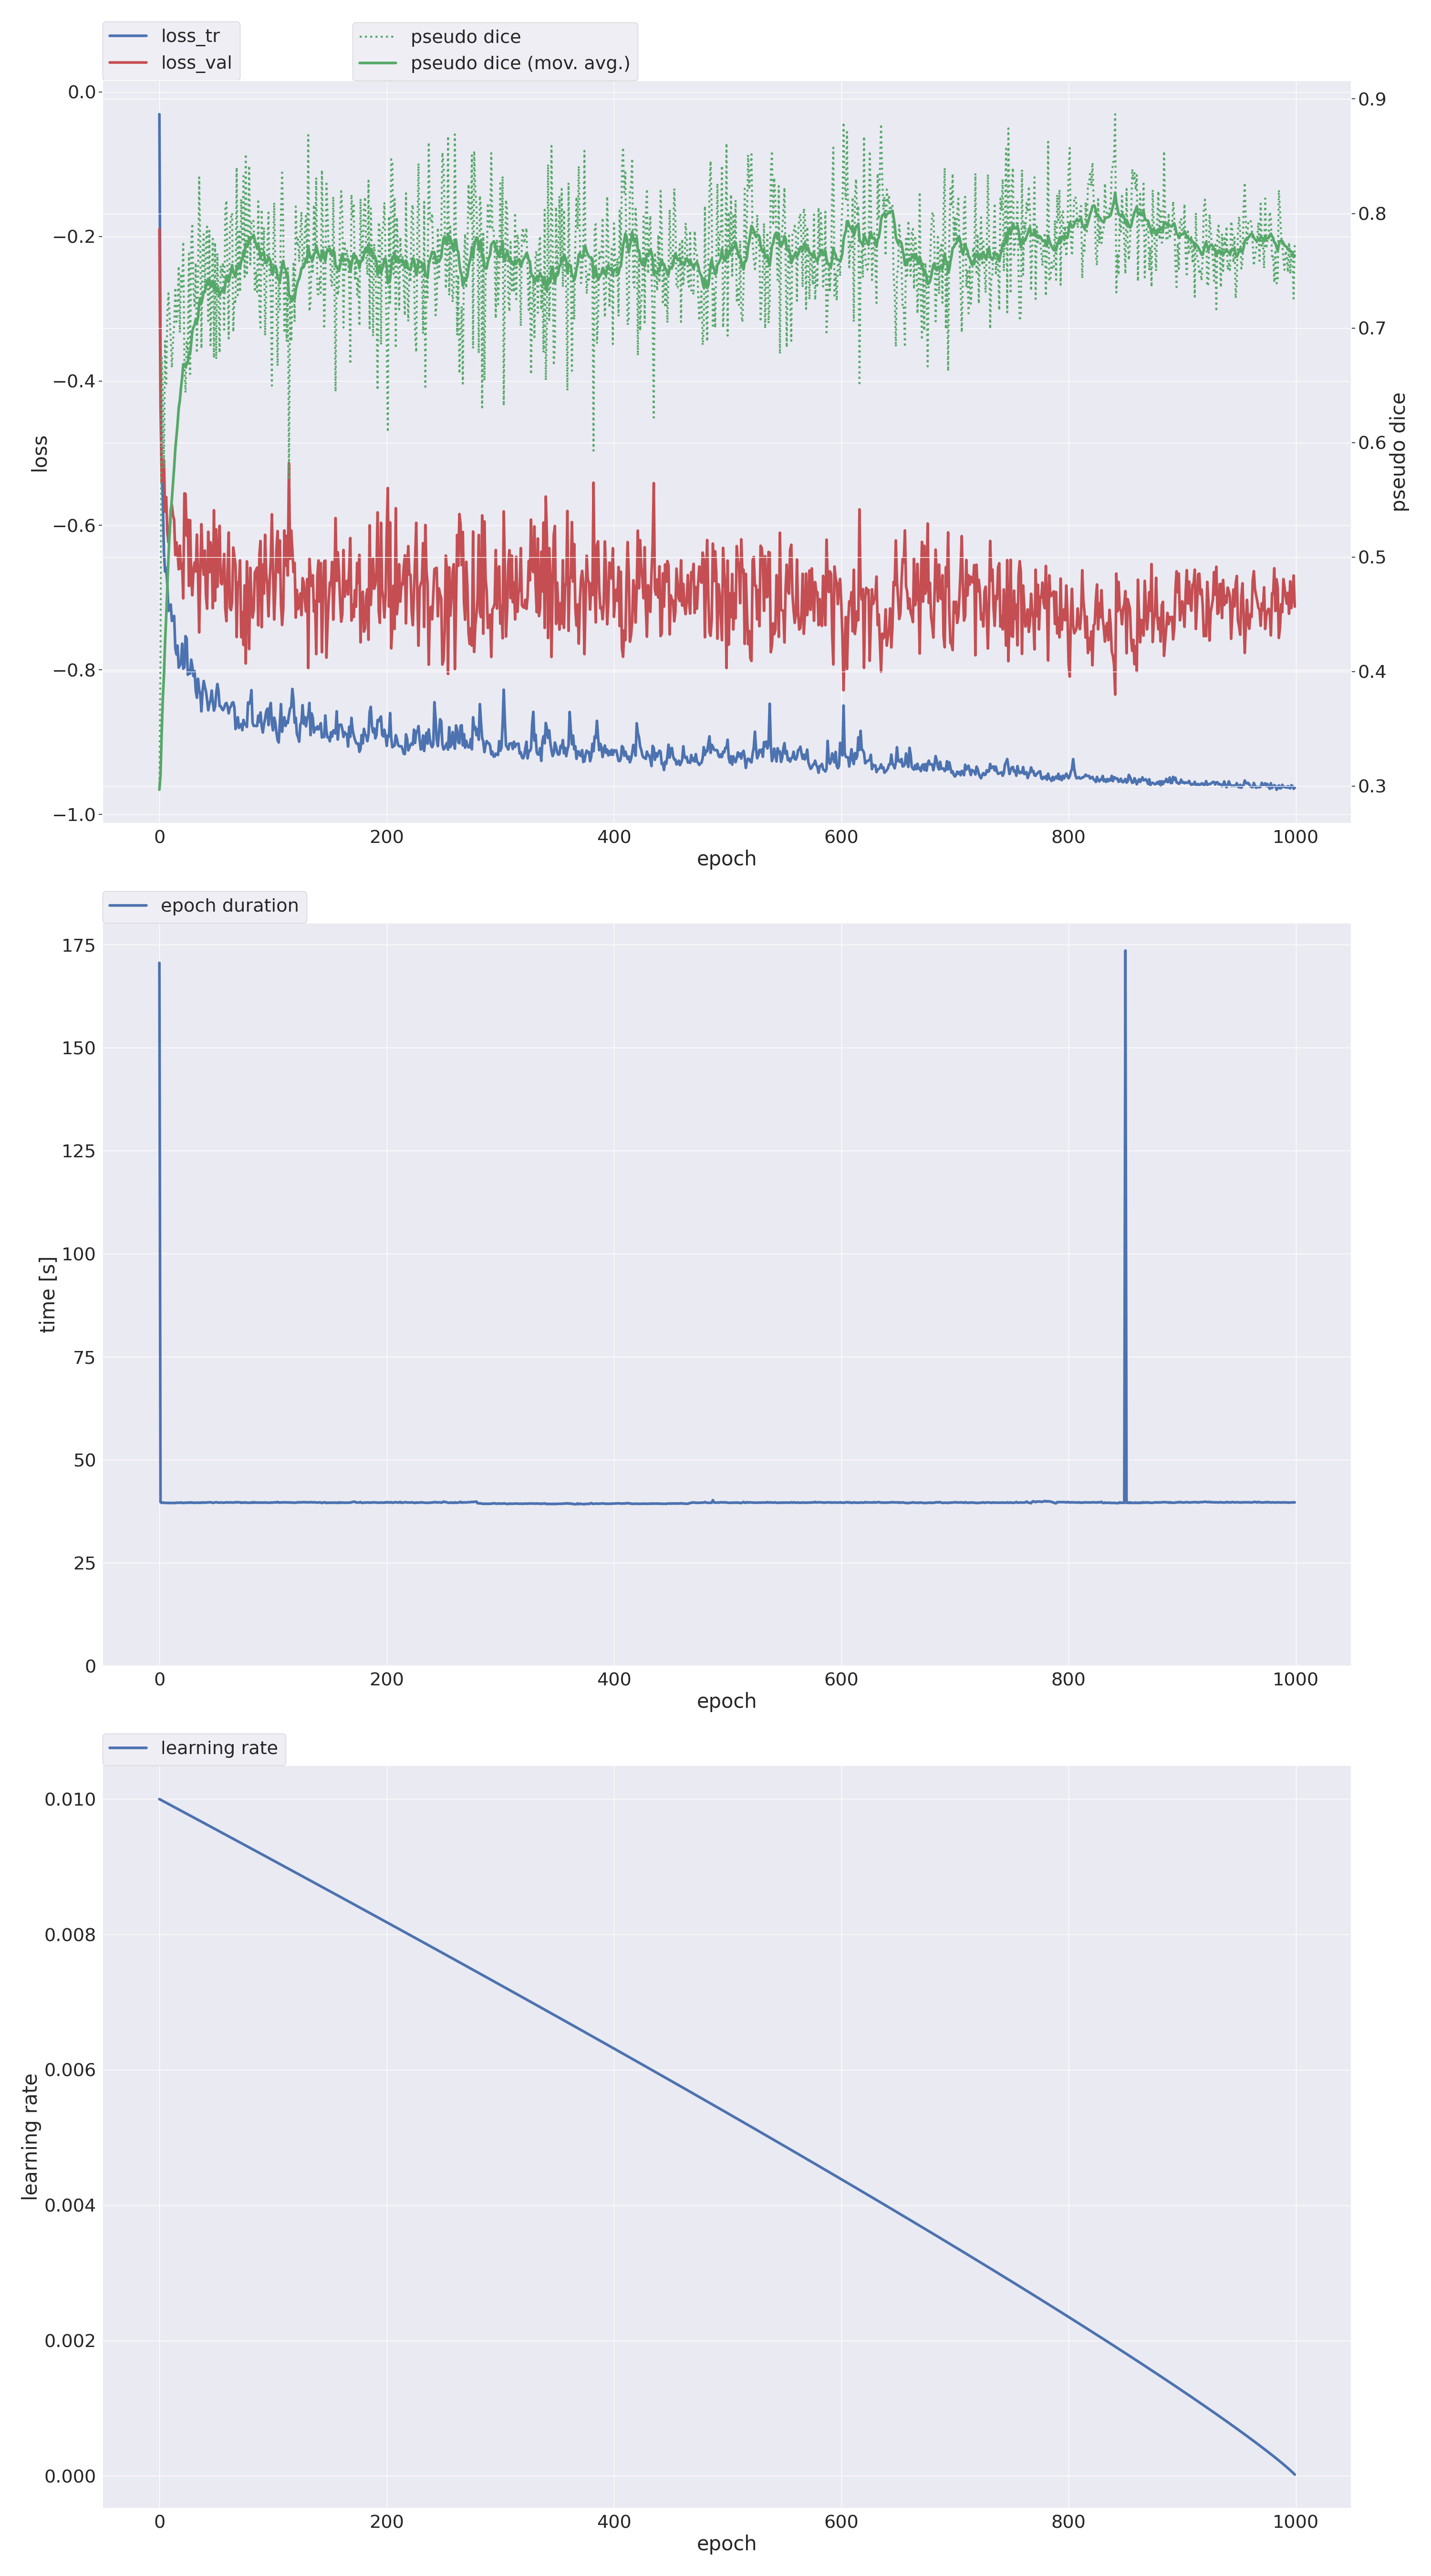

To preserve the sanctity of space, we shall not include the other 4 fold images here, but they can be found in our report summary. Please scroll down to the results section to see an analysis of our performance using this 2D model.

<a id="Results"></a>
## 5. Results
Results are clearly shown, discussed, evaluated using appropriate metrics. Good use of graphs or other visualizations, where possible. Comparison with previous methods/State-of-theart, where appropriate [3]

### 5.1 UNet

Running the model over the testing set gives a mean dice score of **0.6114**, but what is holding it back? We can use the following snippet to generate some samples for visualisation in how the UNet performs.

In [ ]:
with torch.no_grad():
    model.eval()

    for images, masks in test_data:
        images = images.float().to(device)
        masks = masks.squeeze(0).squeeze(0).cpu()

        outputs = model(images)
        print(outputs)
        outputs = outputs.squeeze(0).squeeze(0).cpu()
        outputs[outputs < 0] = 0
        outputs[outputs > 0] = 1
        #outputs = torch.round(torch.sigmoid(outputs))
        #outputs = outputs.squeeze(0).squeeze(0).cpu()
        print(outputs)
        print(masks)
        plt.figure()
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(outputs, cmap="gray")
        axarr[1].imshow(masks, cmap="gray")
        break

The snippet will generate the model's prediction (left) and the true mask (right) for a random slice at each execution, allowing some visualisation without having to print out thousands of images and predictions. From some of these samples, we see that the network works quite well in many cases (middle), but sometimes predicts too conservatively (bottom) or searches for a kidney where there is none (top). This is likely due to the fact that the 2D network uses each slice individually, thus causing the slices without any kidney (approximately half the dataset) to be little more than an abundant negative sample. Thus, it loses its original advantage of using contextual and spacial information from the background to assist it, causing it to sometimes predict a kidney where there is none, or less kidney where there is some. This is one of the greater downsides of a 2D model adaptation with slices, which is fixed in 3D adaptations of the network.

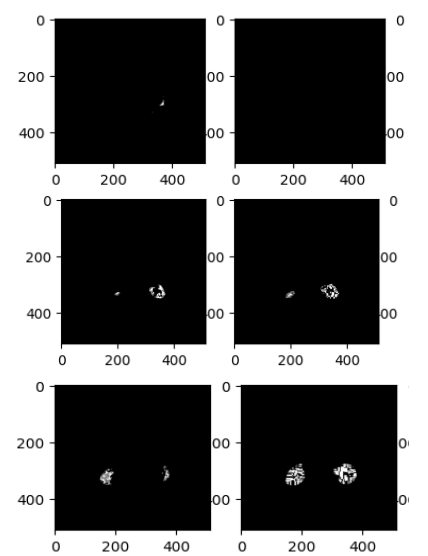

Considering the many drawbacks of applying the 2D network for slices of the data, and the compromises made for computation and time, the original UNet scored a reasonable average of **0.6114** over the unseen testing set.

### 5.2 VNet

Over 300 epochs, the mean dice score: **0.6145**. The training and testing set can be used by the main function above in the VNet section of models. While this model has performed better on the same dataset, due to changes that had to be made to the model because of the computational and time constraints, decreased the accuracy of this model, while the limited dataset also led to overfitting.

As seen below in the graph, the average dice score settles around the final value of 0.6145. The usage of chunks of the 3D imagery instead of the full images leads to an impact on the linking of axial relationships of the kidney. Using a smaller image size, or access to an industrial level GPU would probably enable the model to be run with the full amount of parameters.



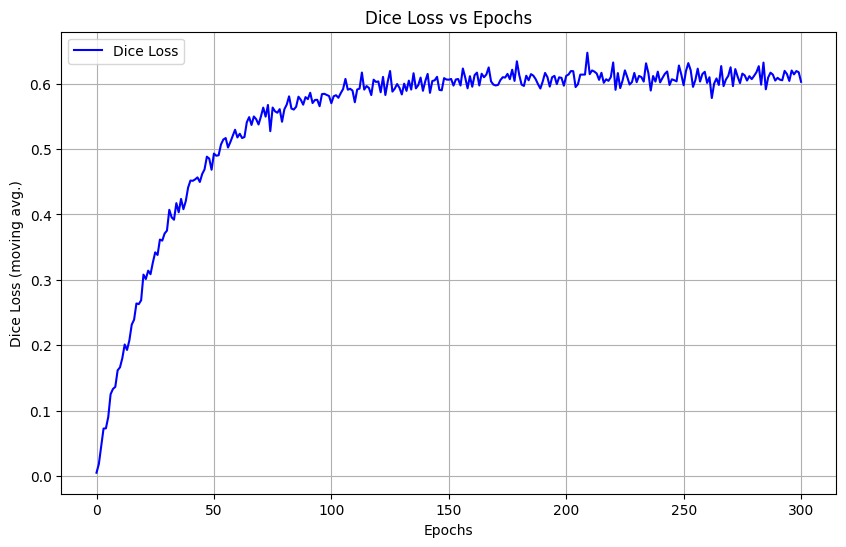





### 5.3 SAMNet

It was found that when manually selecting the masks generated by SAM-Net an outstanding dice score of 0.9+ is obtainable as seen in the image below.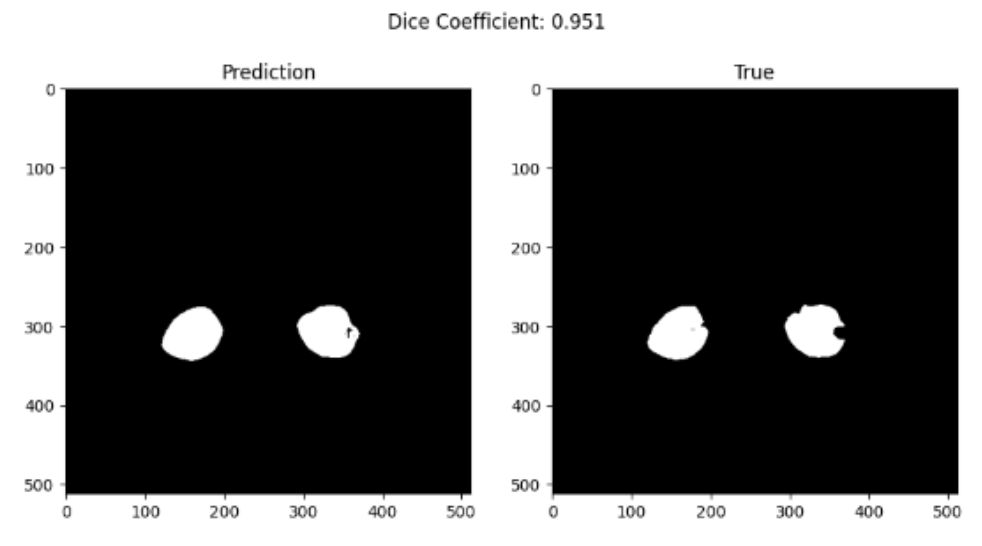

However as mentioned in the methods section we wanted this to be a fully automated procedure and thus connected the SAMNet masks to a secondary neural network to find the most kidney-like masks.

Doing so obtains a Dice score of **0.4659** for the single mask model and a score of **0.6278** for the double mask model. It is not suprising that by combining the best two masks together an improved dice score is obtained as in most test slices, two distinct kindeys were present in the image, each represented by one SAMNet mask. Increasing the number of masks combined beyond 2 starts to decrease the overall dice score as it starts selecting to much area to be classified as kidney.

This model's results are greatly limited by false positives. In cases where there are no kidneys in the image, the neural network still selects the two most kidney-like masks from SAMNet's segmentation not regonising the lack of kidney. This produces outputs like the following which although appear to be similar in position, size and shape to some kidneys, recieves a DICE Score of 0 as there is no actual kidney segmentation in the image to match.

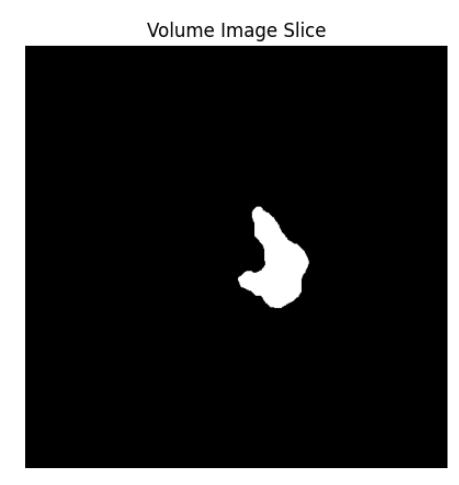

A modification of the model architecture to allow for a 3D implementation could resolve the issue of having no kidney segmentation in a slice by removing individual slices all together, rather using a volumetric approach. This is discussed further in the discussion section of the report below.

### 5.4 nnUNet





#### Numbers
| Fold | Mean Validation Dice |
| :-: | :------: |
| 0   | 0.73045 |
| 1   | 0.86424 |
| 2   | 0.84887 |
| 3   | 0.80907 |
| 4   | 0.79151 |

Mean of the mean validation dice scores: **0.80843**

Standard Deviation: **0.051**

#### Intepretation
The number 1 winner for this challenge scored a mean dice score of 0.9256 ([link](https://kits19.grand-challenge.org/evaluation/challenge/leaderboard/))

We scored a robustly tested, not-a-fluke score of 80.84.

Considering our training and validation loss in the context of Machine Learning to pinpoint areas of improvement, we can see that the red line (validation loss) is converging to the blue line (training loss). However, beyond epoch 600 there is no significant improvement on this gap, and furthermore, we are still sitting too high above our acceptible error bound $\epsilon$. As such, seeing more data will not help our situation, and we are sitting in a **HIGH BIAS** regime.

To fix this problem, we need to increase the complexity of our model, which we can very simply do with the following command:


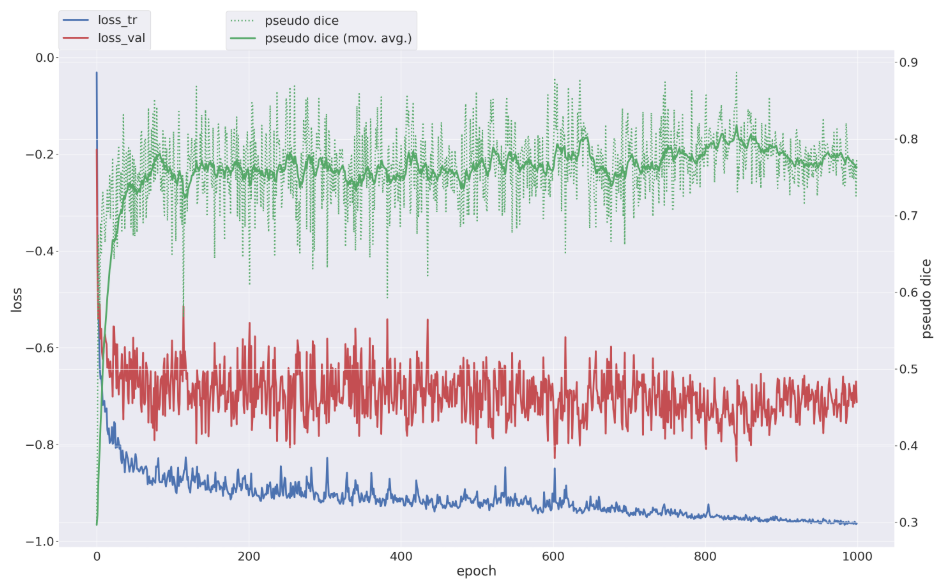

In [ ]:
nnUNetv2_train 1 3d_fullres 0 -tr nnUNetTrainer_250epochs`

Note, now the shift in attitude from letting `nnUNetv2_train` choose my trainer (the `-tr` flag), to now using `nnUNetTrainer_250epochs`.

This is because compute is currency, and I've learned over the course of this project to only request resources when we really need them: what if after 250 epochs the error losses of the model sufficiently converge to below my threshold epsilon. I'm done, and no further work needs to be done.


<a id="Discussion"></a>
## 6. Discussion
 The model’s performance is promising to consider that two of the models are nearly 10 years old. The following are points of discussion which are important to this report.




### 6.1 Dataset
The dataset while expansive and containing a large amount of information, to achieve a higher level of accuracy the number of cases needs to be extended. While consisting of around 200 labelled cases, and 100 validation cases, the dataset pales in comparison to other dataset both in the computer vision field and the medical image segmentation field. This leaves the model prone to overfitting. Other problems with the dataset include the missing context of tumour type as all tumor types are grouped together and no distinction is made between the various types such as benign, malignant and premalignant.
The dataset is also missing anatomical context, such that the tumor may have spread from various different regions in the body.



### 6.2 Models
The dataset includes various other information including age, ethnicity, gender and other health related data which isn’t taken into account due to these models not incorporating statistical data about each case’s relevant health data.


#### 6.2.1 UNet
The standard implementation of UNet struggles with segmenting complex tasks due to the limited generalising nature of the model’s architecture. The existing architecture needs to be extensively modified for the usage with volumetric data (unless 2D slices are used). Hence, the volumetric relationships of the 3D image are lost. For these larger images, the global context is lost, causing larger images and complex structures to be missed.

It is worth noting that this implementation segments only the kidney without consideration for the tumour(was not required), which likely would've drastically decreased its performance as 2D networks are known to struggle with detecting small objects in 3D images converted to slices, something already evident in its detection of the kidney on negative samples.

It is worth noting that the 3D-UNet adaptation of this model is the near-undisputed state of the art thus far, which was unfortunately not possible to train on everyday at-home hardware.

#### 6.2.2 VNet
To start, the larger number of parameters and the usage of 3D convolutions needs to high computational requirements, which leads to an increase in training time, limiting the number of epochs needed. On smaller dataset, and the larger number of parameters of VNet can lead to overfitting.




#### 6.2.3 SAMNet
While the benefits of Meta's pretrained model allow for simple and accurate image segmentation it is unable to naturally identify which of the produced masks belong to the kidney without extensive domain knowledge.
Our solution of extracting the mask information and feeding it into a secondary neural network proved to be a relatively simple extension of the model which solved our problem.

However, the model architecture continues to be limited by false positives. Since the secondary network has been tasked to identify and predict the combination of the two most kidney-like masks provided to it, it performs poorly when the target segmentation does not contain any kidney. Unfortunately this was the case for many of the image slices and thus the overally performance of the model was limited.

Potentially a modification of SAMNet2 which is designed for video segmentation, could be used for a solution to this problem. The 3D volumes could be treated as videos with flat slices being frames and the third dimension being treated as time. Treating the problem in this 3D perspective would resolve the issue of having slices without any kidneys to identify, however it requires extensive computational power and time which were unfortunately unavailable to us for this particular project.


#### 6.2.4 nnU-Net
As important as performance and reproducibility of results are, interpretability and an understanding of what your model is doing is equally important.


We found that whilst it was an enjoyable process learning how to configure nnUNet, we lacked the barebones understanding on UNet that other approaches might have benefitted from --- even if that meant that their baseline was potentially misinformed, and would lack the ability to be generalised to other problemsets.

We know there is certainly improvement to be had here with respect to training more sophisticated models, and then ontop of that adding **DATA-AUGMENTATION** too.

We also, unfortunately did not get to dip our toes into the `extending-nnunet.md` file of the documentation, which has further improvements to tweak our good-and-honest baseline implementation.

Overall, we believe choosing this framework was a good long term decision, in that many problems will now have the same pipeline, but in the short-term there remains much about the internal workings of this framework that eludes us.
